In [4]:
import timeit

import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from toolsets.file_io import get_file_list
import toolsets.ff_droup as ff
from toolsets.search import string_search, quick_search_values, quick_search_sorted
from skimage.restoration import denoise_wavelet
import seaborn as sns
import matplotlib.pyplot as plt
from pybaselines import utils
import pybaselines
import toolsets.spectra_operations as so
# eic_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/gut_microbiom/EICs_snip_baseline_estimate'
from tqdm import tqdm
mzml_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/gut_microbiom/HILIC pos mode mzml'
master_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/gut_microbiom'
file_list = get_file_list(mzml_dir, '.mzML', with_tail=False)
pl_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/gut_microbiom/HILIC pos mode mzml_pl'
from toolsets.file_io import prepare_sample_list
import os
import time

In [9]:
file_list = get_file_list(mzml_dir, '.mzML', with_tail=True)

In [274]:
istd_info = pd.read_csv(os.path.join(master_dir, 'CORE_posHILIC_mzrt_5minMtd_correctionSheet.csv'))

In [6]:
import metabengine.raw_data_utils as rdu
from metabengine.params import Params

In [ ]:
all_bin = ff.get_mz_bin()

In [458]:
ms1, ms2 = ff.process_mzml(os.path.join(mzml_dir, file_list[0]))


In [444]:
len(ms2)

1714

In [257]:
mass_sorted, intensity_sorted, index_sorted, rt_list = ff.build_index(ms1)

In [411]:
# seed_ms2 = ms2.iloc[np.argmax(ms2['ms1_precursor_intensity'])]
# pmz = seed_ms2['ms1_pmz']
# intensity_list = ff.flash_eic(pmz, mass_sorted, intensity_sorted, index_sorted)
# n_neighbor = 2
# intensity_list_smoothed = ff.moving_average(intensity_list, n_neighbor=n_neighbor)
# baseline = pybaselines.smooth.snip(
#     intensity_list_smoothed, max_half_window=30, decreasing=True, smooth_half_window = 5
# )[0]
# baseline = [0 if x <0 else x for x in baseline]
# peak_list = ff.get_peaks(intensity_list_smoothed)
# target_peak_idx = ff.find_most_close(peak_list, rt_list, seed_ms2['ms1_rt'], return_index=True)
#
# target_peak = ff.connect_peaks(peak_list, target_peak_idx, intensity_list, rt_list)
#
# noise_level = np.median(baseline[target_peak[0]:target_peak[2]+1])
#
# rt_start, rt_end = rt_list[target_peak[0]], rt_list[target_peak[2]]
# rt_apex, int_apex = ff.get_centroid(target_peak, rt_list, intensity_list)
# if rt_apex != rt_apex:
#     rt_apex = rt_list[target_peak[1]]
# snr = intensity_list_smoothed[peak_list[target_peak_idx][1]]/baseline_median
# ms2_pmz_sorted = ms2.sort_values(by ='ms1_pmz', ascending=True)
# ms2_rt_sorted = ms2.sort_values(by = 'ms1_rt', ascending=True)
# start = time.time()
# ff.find_scan_fast(pmz, rt_start, rt_end, ms2_pmz_sorted, ms2_rt_sorted)
# end = time.time()
# print(end-start)

In [540]:
ms2 = ms2_raw.copy()

In [520]:
pmz_list = []
rt_apex_list = []
rt_start_list = []
rt_end_list = []
rt_offset_list = []
mz_offset_list = []
reci_snr_list = []
peak_purity_list =[]
msms_list = []
peak_apex_intensity_list =[]
peak_ms1_scan_range_list = []
ms2_scan_idx_range_list = []
mix_list = []

start = time.time()
while(len(ms2))>0:
    ms2_pmz_sorted = ms2.sort_values(by = 'ms1_pmz', ascending=True)
    ms2_rt_sorted = ms2.sort_values(by = 'ms1_rt', ascending=True)
    seed_ms2 = ms2.iloc[np.argmax(ms2['ms1_precursor_intensity'])]
    pmz = seed_ms2['ms1_pmz']
    intensity_list = ff.flash_eic(pmz, mass_sorted, intensity_sorted, index_sorted)
    n_neighbor = 2
    intensity_list_smoothed = ff.moving_average(intensity_list, n_neighbor=n_neighbor)
    baseline = pybaselines.smooth.snip(
        intensity_list_smoothed, max_half_window=30, decreasing=True, smooth_half_window = 5
    )[0]
    baseline = [0 if x <0 else x for x in baseline]
    peak_list = ff.get_peaks(intensity_list_smoothed)
    target_peak_idx = ff.find_most_close(peak_list, rt_list, seed_ms2['ms1_rt'], return_index=True)
    if len(peak_list) >0 and target_peak_idx != -1:
        target_peak = ff.connect_peaks(peak_list, target_peak_idx, intensity_list, rt_list)
        noise_level = np.median(baseline[target_peak[0]:target_peak[2]+1])
        rt_start, rt_end = rt_list[target_peak[0]], rt_list[target_peak[2]]
        rt_apex, int_apex = ff.get_centroid(target_peak, rt_list, intensity_list)
        if rt_apex != rt_apex:
            rt_apex = rt_list[target_peak[1]]
        reci_snr = noise_level/intensity_list_smoothed[peak_list[target_peak_idx][1]]
        mapped_ms2_index=ff.find_scan_fast(pmz, rt_start-5e-07, rt_end+5e-07, ms2_pmz_sorted, ms2_rt_sorted)
        mapped_ms2 = ms2.loc[mapped_ms2_index]
        feature_pmz = (mapped_ms2['ms1_pmz']*mapped_ms2['ms1_precursor_intensity']).sum()/(mapped_ms2['ms1_precursor_intensity'].sum())
        pmz_list.append(feature_pmz)
        rt_apex_list.append(rt_apex)
        rt_start_list.append(rt_start)
        rt_end_list.append(rt_end)
        rt_offset_list.append(abs(rt_apex-seed_ms2['rt']))
        mz_offset_list.append(abs(feature_pmz-seed_ms2['precursor_mz']))
        reci_snr_list.append(reci_snr)
        peak_purity_list.append(seed_ms2['peak_purity'])
        msms_list.append(seed_ms2['peaks'])
        peak_apex_intensity_list.append(int_apex)
        peak_ms1_scan_range_list.append(list(target_peak))
        ms2_scan_idx_range_list.append(list(mapped_ms2['scan_idx']))
        mix_list.append(seed_ms2['mix'])
        ms2.drop(mapped_ms2_index, inplace=True)

    else:
        ms2 = ms2[ms2['scan_idx']!=seed_ms2['scan_idx']]
    # print(len(ms2))
    # break
end = time.time()

In [526]:
features = pd.DataFrame(zip(pmz_list,
                            rt_apex_list,
                            peak_apex_intensity_list,
                            rt_start_list,
                            rt_end_list,
                            rt_offset_list,
                            mz_offset_list,
                            reci_snr_list,
                            peak_purity_list,
                            msms_list,
                            peak_ms1_scan_range_list,
                            ms2_scan_idx_range_list,
                            mix_list),
                        columns=['precursor_mz', 'rt_apex', 'ms1_intensity','rt_start', 'rt_end','rt_offset', 'mz_offset', 'reci_snr','peak_purity', 'msms', 'peak_ms1_scan_range', 'ms2_scan_idx_range_list', 'mix']
                        )

In [535]:
features.sort_values(by = 'precursor_mz')

,precursor_mz,rt_apex,ms1_intensity,rt_start,rt_end,rt_offset,mz_offset,reci_snr,peak_purity,msms,peak_ms1_scan_range,ms2_scan_idx_range_list,mix
214,80.131035,1.870485,7.119795e+06,1.830522,2.058993,0.000441,6.235582e-06,0.013943,0.975320,60.074764251708984\t56111.47265625\n60.0860748...,"[429, 439, 486]",[1316],Schebesta0584_MX741718_posBA_apbCSM9P1-077
324,84.125999,1.174238,2.925784e+06,1.113997,1.397525,0.001080,3.260049e-07,0.001057,1.000000,65.0990219116211\t3579.558349609375\n65.109191...,"[258, 273, 325]","[845, 818]",Schebesta0584_MX741718_posBA_apbCSM9P1-077
496,84.959809,2.926826,7.964319e+05,2.599310,3.042507,0.076221,7.984788e-06,0.090056,0.864074,66.11526489257812\t2558.82666015625\n68.129577...,"[611, 682, 706]","[2021, 2051, 1997]",Schebesta0584_MX741718_posBA_apbCSM9P1-077
233,85.028488,2.052399,5.362896e+06,1.970165,2.288300,0.005898,3.126388e-13,0.022025,0.989332,66.11558532714844\t3663.464111328125\n71.68159...,"[464, 484, 540]",[1457],Schebesta0584_MX741718_posBA_apbCSM9P1-077
3,85.132189,1.163250,2.596772e+08,1.092295,1.647494,0.001644,3.232387e-05,0.002524,0.952940,63.780338287353516\t149110.046875\n66.10541534...,"[253, 270, 384]","[808, 835, 997, 970, 862, 889, 1021, 779, 943,...",Schebesta0584_MX741718_posBA_apbCSM9P1-077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,834.608793,0.432952,6.372700e+07,0.342663,0.561416,0.003981,2.980856e-05,0.003627,0.981626,64.65856170654297\t45649.99609375\n68.94888305...,"[77, 99, 129]","[265, 319, 292]",Schebesta0584_MX741718_posBA_apbCSM9P1-077
379,838.837830,1.811581,2.550462e+06,1.785768,1.871624,0.018245,1.831055e-04,0.000754,0.894045,86.67054748535156\t4233.0947265625\n90.7278442...,"[418, 425, 439]",[1286],Schebesta0584_MX741718_posBA_apbCSM9P1-077
279,839.564026,0.407980,4.578305e+06,0.342663,0.540449,0.000150,1.301425e-04,0.003503,0.990531,78.07720947265625\t3943.94775390625\n107.81349...,"[77, 93, 124]",[278],Schebesta0584_MX741718_posBA_apbCSM9P1-077
185,839.564392,0.294333,7.539743e+06,0.258413,0.376158,0.003108,3.970413e-04,0.001785,0.987971,65.43170166015625\t5203.4072265625\n70.3214950...,"[55, 65, 85]",[196],Schebesta0584_MX741718_posBA_apbCSM9P1-077


In [543]:
86.096440-86.135500

-0.0390599999999921

In [541]:
ms2[ms2['scan_idx'].isin(features.loc[38]['ms2_scan_idx_range_list'])]

,scan_idx,cycle,ms_level,precursor_mz,charge,rt,peaks,isolation_window,ms1_pmz,ms1_rt,ms1_precursor_intensity,peak_purity,mz_offset,mix,base_name
544,802,267,2,128.064346,1,1.153492,84.0745849609375\t81095.6171875\n86.0602645874...,"(127.56434631347699, 128.564346313477)",128.064316,1.151297,4781640.50,0.988455,3.051758e-05,Schebesta0584_MX741718_posBA_apbCSM9P1-077,Schebesta0584_MX741718_posBA_apbCSM9P1-077.mzML
545,748,249,2,128.064330,1,1.079342,79.38102722167969\t29578.236328125\n81.0525207...,"(127.56433105468801, 128.564331054688)",128.064316,1.077150,44886060.00,0.975457,1.390346e-05,Schebesta0584_MX741718_posBA_apbCSM9P1-077,Schebesta0584_MX741718_posBA_apbCSM9P1-077.mzML
546,775,258,2,128.064307,1,1.116192,81.0524673461914\t16522.76171875\n84.074562072...,"(127.564300537109, 128.564300537109)",128.064331,1.113997,17610732.00,0.975674,2.452282e-05,Schebesta0584_MX741718_posBA_apbCSM9P1-077,Schebesta0584_MX741718_posBA_apbCSM9P1-077.mzML
547,830,276,2,128.064331,1,1.192999,69.55332946777344\t1939.452880859375\n70.06481...,"(127.56433105468801, 128.564331054688)",128.064346,1.189497,2192534.25,0.962645,1.525879e-05,Schebesta0584_MX741718_posBA_apbCSM9P1-077,Schebesta0584_MX741718_posBA_apbCSM9P1-077.mzML
548,718,239,2,128.064346,1,1.040276,65.66142272949219\t27848.927734375\n71.9055709...,"(127.56434631347699, 128.564346313477)",128.064346,1.038081,41615696.00,0.979475,1.648376e-07,Schebesta0584_MX741718_posBA_apbCSM9P1-077,Schebesta0584_MX741718_posBA_apbCSM9P1-077.mzML
549,691,230,2,128.064378,1,1.004403,74.43490600585938\t14423.845703125\n81.0525894...,"(127.564376831055, 128.564376831055)",128.064362,1.002208,22845172.00,0.982527,1.613829e-05,Schebesta0584_MX741718_posBA_apbCSM9P1-077,Schebesta0584_MX741718_posBA_apbCSM9P1-077.mzML
550,664,221,2,128.064360,1,0.969309,73.93099975585938\t5895.79296875\n81.052558898...,"(127.564361572266, 128.564361572266)",128.064392,0.967115,10036444.00,0.977576,3.205801e-05,Schebesta0584_MX741718_posBA_apbCSM9P1-077,Schebesta0584_MX741718_posBA_apbCSM9P1-077.mzML


In [533]:
intensity_list = ff.flash_eic(245.097580, mass_sorted, intensity_sorted, index_sorted)

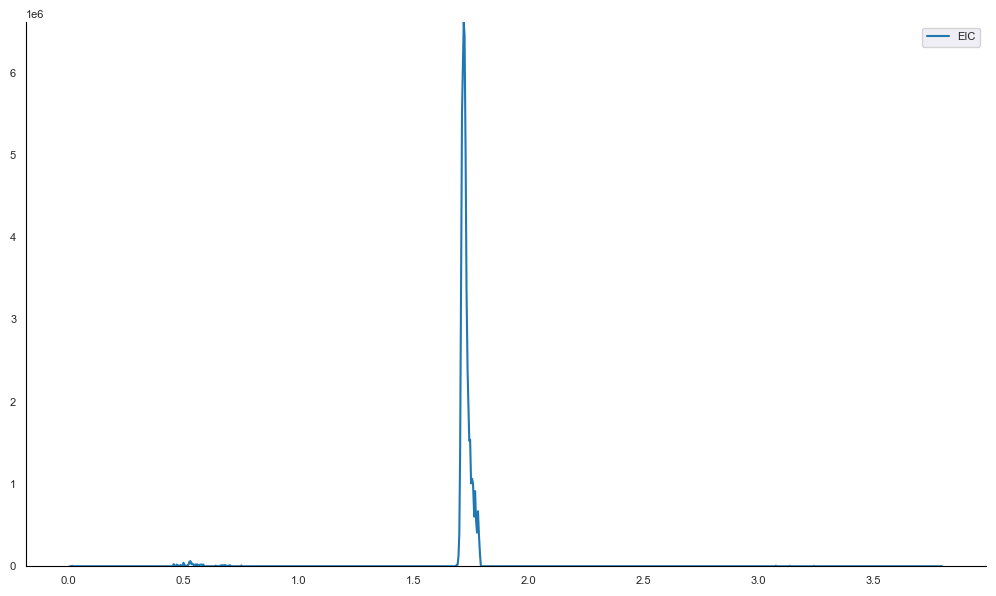

In [534]:
ff.EIC(rt_list, intensity_list)

In [506]:
mapped_ms2.sort_values(by = 'ms1_precursor_intensity', ascending=False, inplace=True)

In [507]:
from toolsets.spectra_plotter import head_to_tail_plot

In [512]:
seed_ms2['ms1_pmz']

104.10694885253906

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

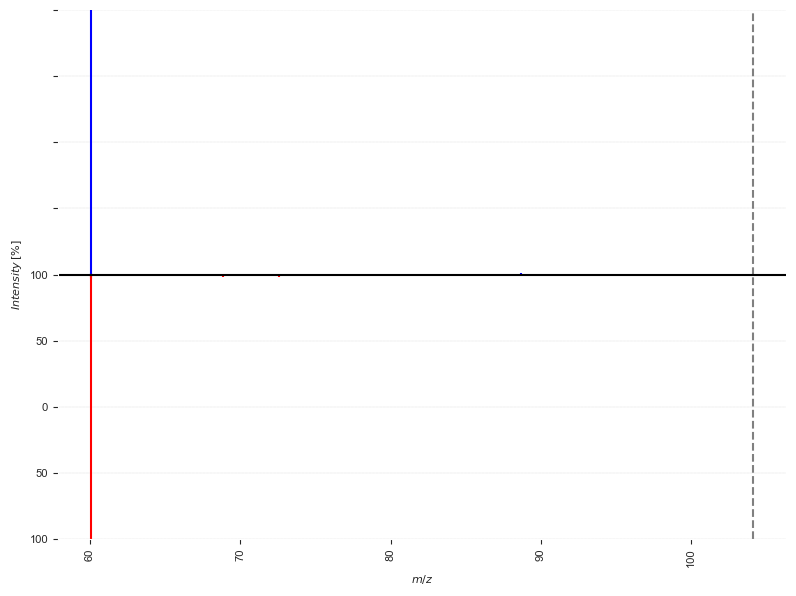

In [510]:
head_to_tail_plot(mapped_ms2.iloc[0]['peaks'],mapped_ms2.iloc[1]['peaks'] ,pmz1 = seed_ms2['ms1_pmz'])

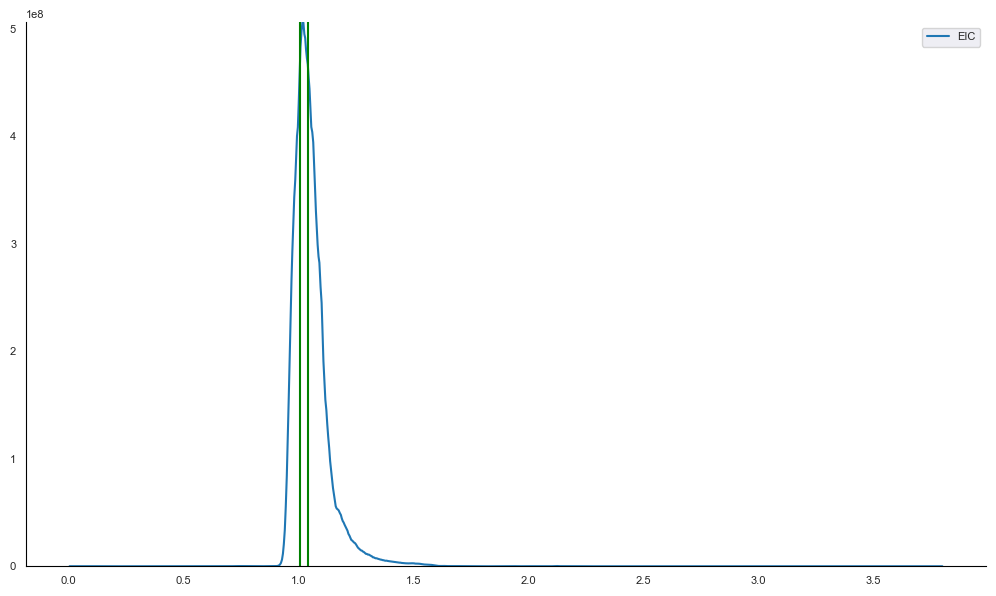

In [501]:
ff.EIC(rt_list, intensity_list_smoothed, vlines_location_2=[seed_ms2['ms1_rt'],1.008438])

In [498]:
(mapped_ms2['ms1_pmz']*mapped_ms2['ms1_precursor_intensity']).sum()/(mapped_ms2['ms1_precursor_intensity'].sum())

104.10695129878607

In [486]:
rt_end-1.950994

-1.9999999989472883e-07

In [481]:
214.0895840-pmz

-3.5058593539361027e-07

In [480]:
1.950994-rt_end

1.9999999989472883e-07

In [475]:
pmz = seed_ms2['ms1_pmz']
intensity_list = ff.flash_eic(pmz, mass_sorted, intensity_sorted, index_sorted)
n_neighbor = 2
intensity_list_smoothed = ff.moving_average(intensity_list, n_neighbor=n_neighbor)
baseline = pybaselines.smooth.snip(
    intensity_list_smoothed, max_half_window=30, decreasing=True, smooth_half_window = 5
)[0]
baseline = [0 if x <0 else x for x in baseline]
peak_list = ff.get_peaks(intensity_list_smoothed)
target_peak_idx = ff.find_most_close(peak_list, rt_list, seed_ms2['ms1_rt'], return_index=True)

In [477]:
mapped_ms2_index

[]

In [452]:
mapped_ms2_index=ff.find_scan_fast(pmz, rt_start, rt_end, ms2_pmz_sorted, ms2_rt_sorted)

AttributeError: 'Series' object has no attribute 'Index'

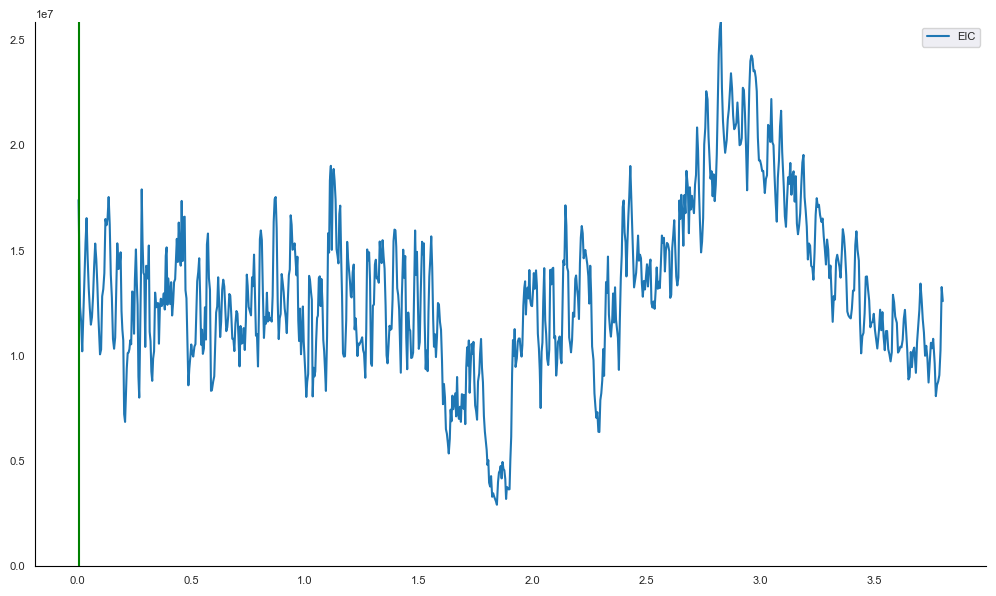

In [438]:
ff.EIC(rt_list, intensity_list_smoothed, vlines_location_2=[0.006649])

In [407]:
ms2['peak_purity'].describe()

count    1714.000000
mean        0.890954
std         0.183241
min         0.002725
25%         0.892964
50%         0.958638
75%         0.985028
max         1.000000
Name: peak_purity, dtype: float64

In [400]:
104.126671

scan_idx                                                                 758
cycle                                                                    252
ms_level                                                                   2
precursor_mz                                                      104.126671
charge                                                                     1
rt                                                                  1.091598
peaks                      60.08099365234375\t25021620.0\n61.918773651123...
isolation_window                        (103.626670837402, 104.626670837402)
ms1_pmz                                                           104.126251
ms1_rt                                                              1.088575
ms1_precursor_intensity                                           1712869.75
peak_purity                                                         0.006209
mz_offset                                                            0.00042

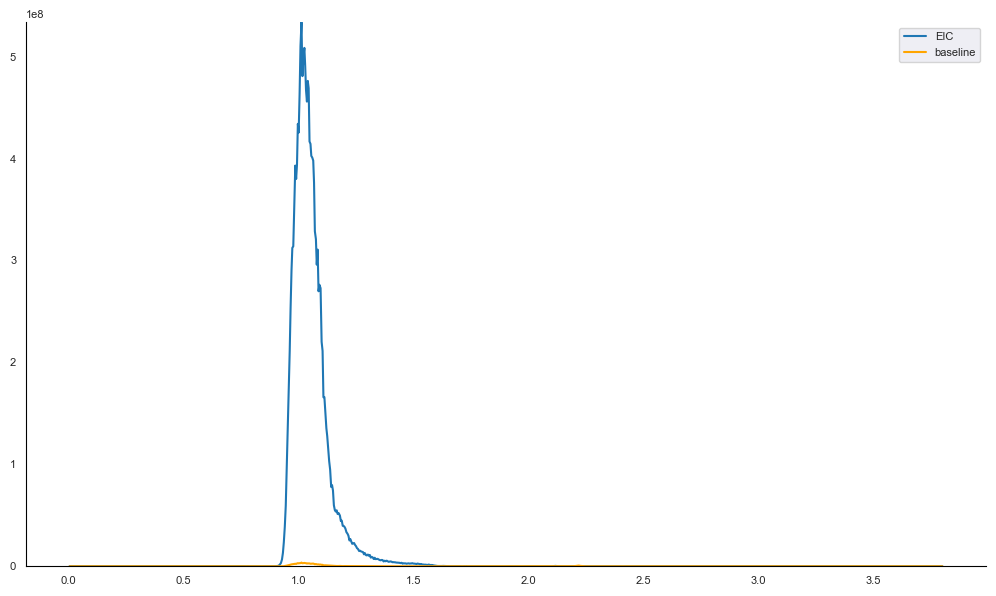

In [417]:
intensity_list =ff.flash_eic(104.126671, mass_sorted, intensity_sorted, index_sorted)
ff.EIC(rt_list, intensity_list_master, base_line_series=intensity_list)

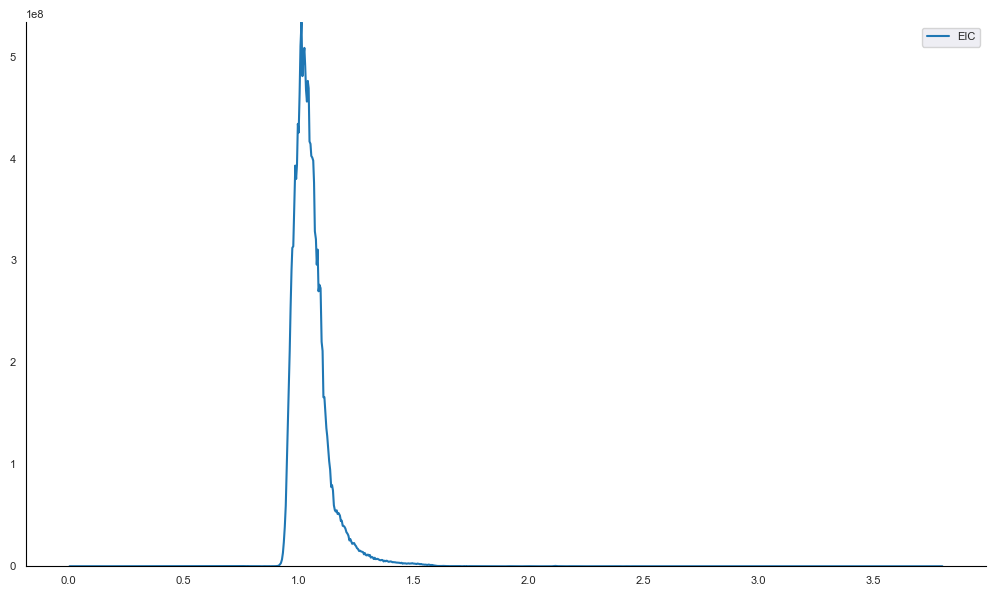

In [414]:
intensity_list_master =ff.flash_eic(pmz, mass_sorted, intensity_sorted, index_sorted)
ff.EIC(rt_list, intensity_list_master)

In [401]:
pmz

104.10694885253906

In [298]:
mass_working = mass_sorted.copy()
intensity_working = intensity_sorted.copy()
index_working = index_sorted.copy()
start = time.time()
mass_working = mass_sorted.copy()
intensity_working = intensity_sorted.copy()
mass_bin = []
mass_slicing = 0.01/2
while len(mass_working)>0:
    idx = np.argmax(intensity_working)
    index_start, index_end = mass_working.searchsorted([mass_working[idx]-mass_slicing,mass_working[idx]+mass_slicing])
    mass_bin.append(mass_working[idx])
    mass_working = np.concatenate((mass_working[0:index_start], mass_working[index_end:]), axis = None)
    intensity_working = np.concatenate((intensity_working[0:index_start], intensity_working[index_end:]), axis= None)
    # break
print(len(mass_bin))

end = time.time()
print(end-start)

41858
2.015395164489746


In [301]:
mass_bin_test = mass_bin[-100:]

In [302]:
len(mass_bin_test)

100

In [309]:
intensity_tolerance = 30000
int_max = []
for m in tqdm(mass_bin):
    intensity_list = ff.flash_eic(m, 0.005, mass_sorted, intensity_sorted, index_sorted)
    # break
    int_max.append(np.max(intensity_list))

100%|██████████| 41858/41858 [00:02<00:00, 14421.56it/s]


In [323]:
np.quantile(int_max, 0.75)

32056.5126953125